# Heuristic Policy

In [1]:
import numpy as np
import gym
from helpers import *

np.random.seed(127)

In [2]:
env = NormalizedEnv(gym.make("Pendulum-v1"))

In [13]:
def run_episode(env, agent):
    state = env.reset()[0]
    trunc = False
    rewards = []
    while not trunc:
        action = agent.compute_action(state)
        action = action[0,0]
        state, reward, _, trunc, _ = env.step(action)
        rewards.append(reward)

    return rewards


In [14]:
rewards = run_episode(env, RandomAgent(env))
print("Total reward for a single episode with a random policy: ", np.sum(rewards))

Total reward for a single episode with a random policy:  -1272.265962756525


In [16]:
mean_reward = np.mean([np.sum(run_episode(env, RandomAgent(env))) for _ in range(100)])
print("Mean reward over 100 episoded with a random policy: ", mean_reward)

Mean reward over 100 episoded with a random policy:  -1228.3144314915694


In [40]:
class HeuristicPendulumAgent(Agent):
    def __init__(self, torque1, torque2):
        self.torque1 = torque1
        self.torque2 = torque2

    def compute_action(self, state: np.ndarray):
        state = np.atleast_2d(state)
        angle = np.arctan2(state[:, 0], state[:, 1]).reshape(-1, 1)
        return np.where(
            angle < 0.0,
            self.torque1 * np.sign(state[:, 2:3]),
            -self.torque2 * np.sign(state[:, 2:3]),
        )


agent = HeuristicPendulumAgent(0.25, 0.25)
mean_reward = np.mean([np.sum(run_episode(env, agent)) for _ in range(100)])
print("Mean reward over 100 episodes with heursitic policy: ", mean_reward)

Mean reward over 100 episodes with heursitic policy:  -812.4765169012625


# Q-function of the heuristic policy

In [41]:
from collections import deque

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import tqdm
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
# set all random seeds
np.random.seed(127)
torch.manual_seed(127)

In [81]:
class ReplayBuffer:
    def __init__(self, capacity: int) -> None:
        self.buffer = deque(maxlen=capacity)

    def __len__(self) -> None:
        return len(self.buffer)

    def append(self, state, action, reward, next_state, trunc) -> None:
        self.buffer.append((state, action, reward, next_state, trunc))

    def sample(self, indices):
        states, actions, rewards, next_states, truncs = zip(
            *(self.buffer[idx] for idx in indices)
        )

        # print(states)
        return (
            np.array(states),
            np.array(actions),
            np.array(rewards, dtype=np.float32),
            np.array(next_states),
            np.array(truncs, dtype=bool),
        )

In [43]:
class QNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(4, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
        )
        # intialize weights with xavier uniform and bias 0
        for m in self.net.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.zeros_(m.bias)

    def forward(self, x: torch.Tensor):
        return self.net(x)

In [47]:
def critic_learning_step(actor, critic, batch, optimizer, gamma):
    states, actions, rewards, next_states, truncs = batch

    # compute the target
    with torch.no_grad():
        next_actions = actor.compute_action(next_states)
        next_q_values = critic(
            torch.from_numpy(np.hstack((next_states, next_actions))).float()
        ).squeeze()
        target = (
            torch.from_numpy(rewards).float()
            + gamma * next_q_values * ~torch.from_numpy(truncs).bool()
        )

    # compute q values using qnetwork
    q_values = critic(
        torch.from_numpy(np.hstack((states, actions.reshape(-1, 1)))).float()
    ).squeeze()

    # compute loss
    loss = F.mse_loss(q_values, target)

    # perform optimizer step
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return loss.item()


def train_qnetwork(
    env,
    agent,
    qnetwork,
    batch_size=128,
    buffer_size=1e4,
    gamma=0.99,
    learning_rate=1e-4,
):
    buffer = ReplayBuffer(int(buffer_size))
    optimizer = optim.Adam(qnetwork.parameters(), lr=learning_rate)

    losses = []
    for _ in tqdm.trange(1000):
        # run an episode with the agent
        state = env.reset()[0]
        trunc = False
        episode_losses = []
        while not trunc:
            action = agent.compute_action(state)
            action = action[0,0]
            next_state, reward, _, trunc, _ = env.step(action)
            buffer.append(state, action, reward, next_state, trunc)
            state = next_state

            if len(buffer) < batch_size:
                continue

            # bootstrap the buffer
            indices = np.random.choice(len(buffer), batch_size, replace=True)
            episode_losses.append(
                critic_learning_step(
                    agent, qnetwork, buffer.sample(indices), optimizer, gamma
                )
            )

        losses.append(np.mean(episode_losses))

    return losses

In [48]:
class EpsilonPolicyWrapper:
    def __init__(self, policy, epsilon):
        self.policy = policy
        self.epsilon = epsilon

    def compute_action(self, state):
        if np.random.rand() < self.epsilon:
            return (
                np.random.uniform(-1, 1)
                if len(state.shape) == 1
                else np.random.uniform(-1, 1, size=state.shape[1])
            )
        else:
            return self.policy.compute_action(state)

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [01:21<00:00, 12.23it/s]


Text(0.5, 1.0, 'Losses')

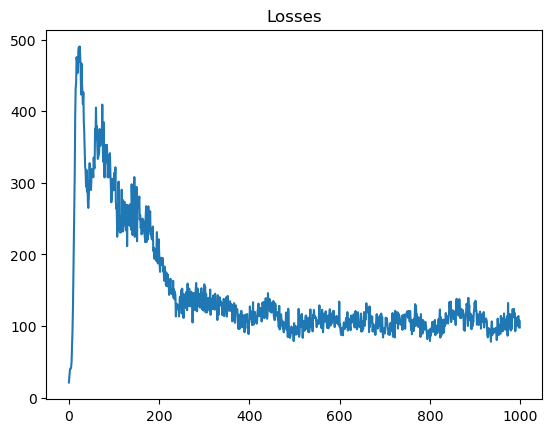

In [49]:
qnetwork = QNetwork()
qnetwork_before_training = QNetwork()
qnetwork_before_training.load_state_dict(qnetwork.state_dict())
losses = train_qnetwork(
    env,
    HeuristicPendulumAgent(0.25, 0.25),
    qnetwork,
    learning_rate=1e-4,
)
plt.plot(losses)
plt.title("Losses")

In [50]:
def polar_heatmap(qnetwork, velocity, torque):
    """
    Plots a polar heatmap with matplotlib where the angle corresponds to the angle of
    the pandulum and the color corrsponds to the magnitude of the Q values.
    Radii should be ignore and patches should be created for each angle.
    """
    angles = np.linspace(-np.pi, np.pi, 100)
    q_values = []
    for i in range(len(angles) - 1):
        angle = 0.5 * (angles[i] + angles[i + 1])
        state_action_pair = np.array([np.cos(angle), np.sin(angle), velocity, torque])
        qnetwork.eval()
        with torch.no_grad():
            q_values.append(
                qnetwork(torch.from_numpy(state_action_pair).float()).item()
            )
    q_values = np.array(q_values).reshape(-1, 1).T

    # plt.subplot(projection="polar")
    plt.pcolormesh(angles + np.pi / 2, np.array([0, 1]), q_values, shading="flat")
    # remove ticks on radial axis 
    plt.rgrids([])
    # set theta ticks lables as 0 on the top and -180/180 on the bottom
    plt.thetagrids([0, 90, 180, 270], ["90", "0", "-90", "-180/180"])
    plt.colorbar()
    # plt.show()

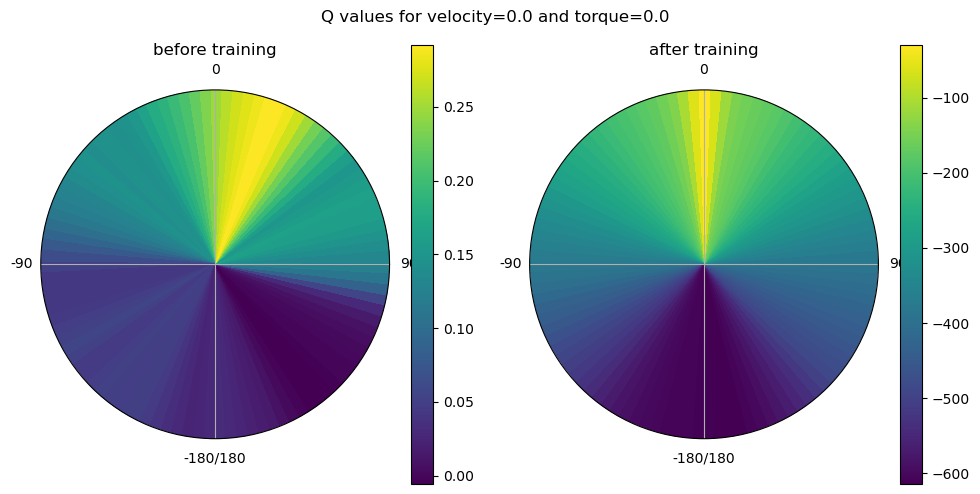

In [51]:
velocity = 0.0
torque = 0.0
plt.figure(figsize=(10, 5))
plt.subplot(1,2,1, projection="polar")
plt.title("before training")
polar_heatmap(qnetwork_before_training, velocity, torque)
plt.subplot(1,2,2, projection="polar")
polar_heatmap(qnetwork, velocity, torque)
plt.title("after training")
plt.suptitle(f"Q values for velocity={velocity} and torque={torque}")
plt.tight_layout()
plt.savefig("qvalues_heatmap.png", dpi=300)

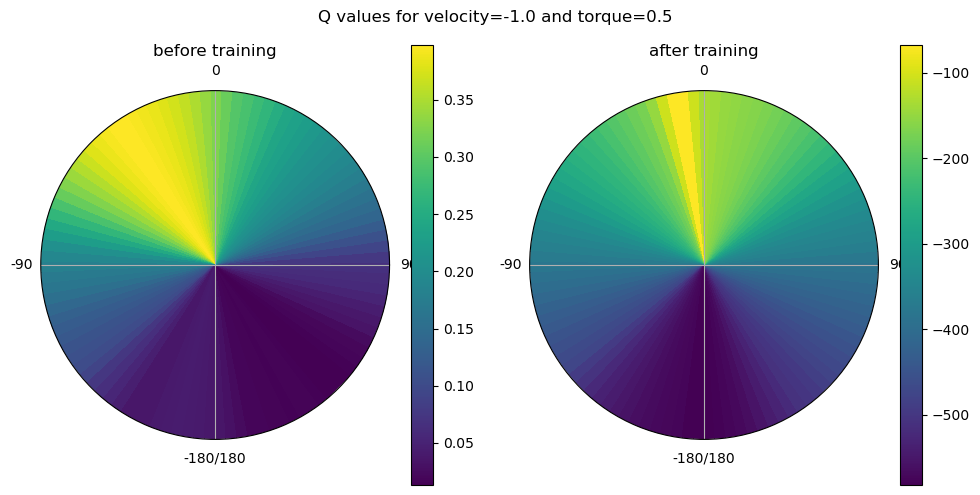

In [54]:
velocity = -1.0
torque = 0.5
plt.figure(figsize=(10, 5))
plt.subplot(1,2,1, projection="polar")
plt.title("before training")
polar_heatmap(qnetwork_before_training, velocity, torque)
plt.subplot(1,2,2, projection="polar")
polar_heatmap(qnetwork, velocity, torque)
plt.title("after training")
plt.suptitle(f"Q values for velocity={velocity} and torque={torque}")
plt.tight_layout()
plt.savefig("qvalues_heatmap.png", dpi=300)

# Minimal implementation of DDPG

In [59]:
class PolicyNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(3, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
            nn.Tanh(),
        )
        # intialize weights with xavier uniform and bias 0
        for m in self.net.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.zeros_(m.bias)

    def forward(self, x):
        return self.net(x)

In [60]:
class GaussianActionNoise:
    def __init__(self, sigma: float) -> None:
        self.sigma = sigma

    def get_noisy_action(self, action):
        if isinstance(action, np.ndarray):
            return np.clip(
                action + np.random.normal(0, self.sigma, size=action.shape), -1, 1
            )
        else:
            return torch.clip(
                action + torch.normal(0, self.sigma, size=action.shape), -1, 1
            )

In [61]:
class DDPGAgent:
    def __init__(self, policy_network: PolicyNetwork, noise: GaussianActionNoise):
        self.policy_network = policy_network
        self.noise = noise

    def compute_action(self, state: torch.Tensor, deterministic=True):
        # state = torch.from_numpy(np.atleast_2d(state)).float()
        state = torch.atleast_2d(state).float()
        if deterministic:
            return self.policy_network(state)
        else:
            return self.noise.get_noisy_action(self.policy_network(state))

In [87]:
def actor_learning_step(actor, critic, batch, optimizer):
    states, _, _, _, _ = batch
    states = torch.from_numpy(states).float()
    # compute loss
    loss = -critic(
        torch.hstack((states, actor.compute_action(states)))
    ).mean()

    # perform optimizer step
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return loss.item()


def critic_learning_step(actor: DDPGAgent, critic: QNetwork, batch, optimizer, gamma):
    states, actions, rewards, next_states, truncs = batch

    # compute the target
    with torch.no_grad():
        next_states = torch.from_numpy(next_states).float()
        next_actions = actor.compute_action(next_states)
        next_q_values = critic(torch.hstack((next_states, next_actions))).squeeze()
        target = (
            torch.from_numpy(rewards).float()
            + gamma * next_q_values * ~torch.from_numpy(truncs).bool()
        )

    # compute q values using qnetwork
    states = torch.from_numpy(states).float()
    actions = torch.from_numpy(actions).float().unsqueeze(1)
    q_values = critic(torch.hstack((states, actions))).squeeze()

    # compute loss
    loss = F.mse_loss(q_values, target)

    # perform optimizer step
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return loss.item()


def train_ddpg(
    env: NormalizedEnv,
    agent: DDPGAgent,
    qnetwork: QNetwork,
    batch_size=128,
    buffer_size=1e4,
    gamma=0.99,
    learning_rate=1e-4,
):
    buffer = ReplayBuffer(int(buffer_size))
    critic_optimizer = optim.Adam(qnetwork.parameters(), lr=learning_rate)
    assert hasattr(agent, "policy_network") and isinstance(
        agent.policy_network, PolicyNetwork
    )
    actor_optimizer = optim.Adam(agent.policy_network.parameters(), lr=learning_rate)

    critic_losses = []
    actor_losses = []
    cumulated_rewards = []
    for _ in tqdm.trange(1000):
        # run an episode with the agent
        state = env.reset()[0]
        trunc = False
        critic_episode_losses = []
        actor_episode_losses = []
        cumulated_reward = 0
        while not trunc:
            # compute action and perform a step in the environment
            with torch.no_grad():
                action = agent.compute_action(torch.from_numpy(state).float())
                action = action[0, 0].item()
            next_state, reward, _, trunc, _ = env.step(action)
            # print(state, action, reward, next_state, trunc)
            buffer.append(state, action, reward, next_state, trunc)
            state = next_state
            cumulated_reward += reward

            if len(buffer) < batch_size:
                continue

            # critic learning step
            # bootstrap the buffer
            qnetwork.train()
            agent.policy_network.eval()
            indices = np.random.choice(len(buffer), batch_size, replace=True)
            critic_episode_losses.append(
                critic_learning_step(
                    agent, qnetwork, buffer.sample(indices), critic_optimizer, gamma
                )
            )

            # actor learning step
            indices = np.random.choice(len(buffer), batch_size, replace=True)
            qnetwork.eval()
            agent.policy_network.train()
            actor_episode_losses.append(
                actor_learning_step(
                    agent, qnetwork, buffer.sample(indices), actor_optimizer
                )
            )

        critic_losses.append(np.mean(critic_episode_losses))
        actor_losses.append(np.mean(actor_episode_losses))
        cumulated_rewards.append(cumulated_reward)

    return critic_losses, actor_losses, cumulated_rewards

In [88]:
qnetwork = QNetwork()
qnetwork_before_training = QNetwork()
qnetwork_before_training.load_state_dict(qnetwork.state_dict())
policy_network = PolicyNetwork()
policy_network_before_training = PolicyNetwork()
policy_network_before_training.load_state_dict(policy_network.state_dict())
noise_std = 0.3
agent = DDPGAgent(policy_network, GaussianActionNoise(noise_std))
critic_losses, actor_losses, cumulated_rewards = train_ddpg(
    env,
    agent,
    qnetwork,
    learning_rate=1e-4,
    batch_size=128,
    gamma=0.99,
    buffer_size=1e5,
)

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [05:47<00:00,  2.88it/s]


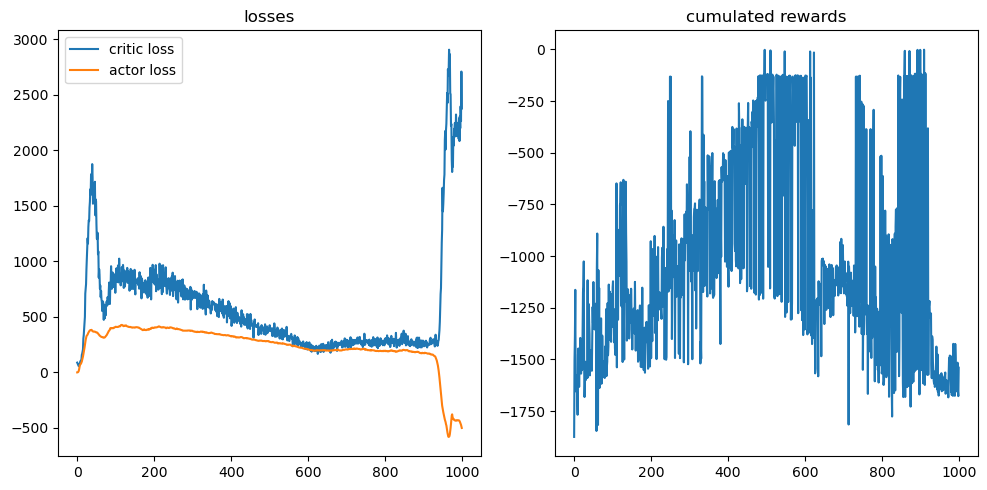

In [89]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(critic_losses, label="critic loss")
plt.plot(actor_losses, label="actor loss")
plt.legend()
plt.title("losses")
plt.subplot(1, 2, 2)
plt.plot(cumulated_rewards)
plt.title("cumulated rewards")
plt.tight_layout()

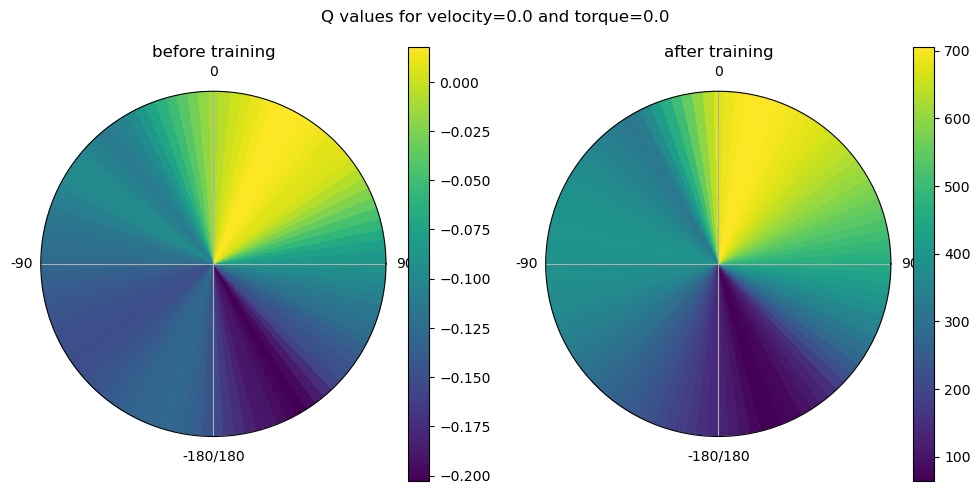

In [91]:
velocity = 0.0
torque = 0.0
plt.figure(figsize=(10, 5))
plt.subplot(1,2,1, projection="polar")
plt.title("before training")
polar_heatmap(qnetwork_before_training, velocity, torque)
plt.subplot(1,2,2, projection="polar")
polar_heatmap(qnetwork, velocity, torque)
plt.title("after training")
plt.suptitle(f"Q values for velocity={velocity} and torque={torque}")
plt.tight_layout()
plt.savefig("qvalues_heatmap.png", dpi=300)